## POS Tagger

In [1]:
import re
import string
import pandas as pd
from collections import Counter
from hazm import sent_tokenize, word_tokenize, Normalizer, POSTagger

In [2]:
comments_df = pd.read_csv(r'Datasets\digikala_comment.csv')
comments_df.head()

,comment
0,نسبت به قیمتش ارزش خرید داره\nجاداره، طراحیش ق...
1,چند ماهی میشه که گرفتمش‌. برای برنامه نویسی و ...
2,پراید ستون جدید
3,اقا همه چیش خوبه فقط از پایین زیاد حاشیه داره ...
4,گوسی هو اوی p10 lite سیپیو و دوربین و رمش از ا...


## Pre-Process

In [3]:
def preprocess_sentences(comments_df):
    # Convert comments into sentences
    normalizer = Normalizer()
    comments_df['sentences'] = comments_df['comment'].apply(lambda comment: sent_tokenize(comment))
    comments_df.drop('comment', axis=1, inplace=True)

    # Convert DataFrame into a list of sentences
    sentences_list = comments_df['sentences'].tolist()
    flat_sentences_list = [sentence for sublist in sentences_list for sentence in sublist]

    normalized_sentences = [normalizer.normalize(s) for s in flat_sentences_list]

    # Remove Zero-Width Non-Joiners
    sentences = [sentence.replace('\u200c', ' ') for sentence in normalized_sentences]

    # Remove English characters from sentences
    cleaned_sentences = []
    english_pattern = re.compile(r'[a-zA-Z]')
    for sentence in sentences:
        cleaned_sentence = ' '.join(word for word in word_tokenize(sentence) if not english_pattern.search(word))
        cleaned_sentences.append(cleaned_sentence)

    # Remove punctuations from sentences
    punctuations = string.punctuation + '،' + '؟'
    cleaned_sentences_final = []
    for sentence in cleaned_sentences:
        cleaned_sentence = ''.join(char for char in sentence if char not in punctuations)
        cleaned_sentences_final.append(cleaned_sentence)

    return cleaned_sentences_final


In [4]:
c = preprocess_sentences(comments_df)

In [5]:
print('Number of sententences:', len(c))
for i in range(10):
    print(c[i])

Number of sententences: 463
نسبت به قیمتش ارزش خرید داره جاداره  طراحیش قشنگه تنها مشکلش بندهای ضعیفش هست که باعث میشه استحکام چندانی نداشنه باشه
چند ماهی میشه که گرفتمش 
برای برنامه نویسی و کارای گرافیکی ازش استفاده می کنم 
واقعا از هر لحاظ بگین عالیه 
پراید ستون جدید
اقا همه چیش خوبه فقط از پایین زیاد حاشیه داره که با روشن شدن گوشی بیشتر هم میشه 
و نکته دیگه اینکه به خاطر این که اطرافش یه کوچلو خمیده هست گلس بعد یه مدتی جدا مشیه 
ولی در کل با این قیمت بهترین گوشی هست و همه چی داره  از دوربین گرفته تا رم و سی پی یو و گرافیک و حسگر های مختلف و خیلی چیزای دیگه 
گوسی هو اوی ۱۰ سیپیو و دوربین و رمش از این خیلی بهتره خودتون میتونین برین تمام مقایسه های ۱۰ این گوشیو ببینین
چادر سبک و زیباییه دوختشم عالیه


## POS Tagging

In [6]:
def pos_tag_sentences(sentences):
    tagger = POSTagger(model='Resources/pos_tagger.model')
    pos_tagged_sentences = []
    
    for sentence in sentences:
        words = word_tokenize(sentence)
        tagged_words = tagger.tag(words)
        pos_tagged_sentences.append(tagged_words)
    
    return pos_tagged_sentences

In [7]:
pos_tagged_sentences = pos_tag_sentences(c)

# POS Tagging results for 1st sentence
for token, pos_tag in pos_tagged_sentences[0]:
    print(f"{token} -> {pos_tag}")

نسبت -> NOUN
به -> ADP
قیمتش -> NOUN
ارزش -> NOUN,EZ
خرید -> NOUN
داره -> VERB
جاداره -> NOUN,EZ
طراحیش -> NOUN
قشنگه -> VERB
تنها -> ADV
مشکلش -> NOUN
بندهای -> NOUN,EZ
ضعیفش -> ADJ
هست -> VERB
که -> SCONJ
باعث -> ADJ,EZ
میشه -> NOUN
استحکام -> NOUN,EZ
چندانی -> ADJ
نداشنه -> VERB
باشه -> VERB


## Tag Counts

In [8]:
all_pos_tags = [tag for sentence in pos_tagged_sentences for _, tag in sentence]

pos_tag_counts = Counter(all_pos_tags)

print("POS Tag Counts:")
for tag, count in pos_tag_counts.items():
    print(f"{tag}: {count}")

POS Tag Counts:
NOUN: 2357
ADP: 804
NOUN,EZ: 1218
VERB: 1341
ADV: 545
ADJ: 747
SCONJ: 294
ADJ,EZ: 179
DET: 254
ADP,EZ: 178
CCONJ: 650
DET,EZ: 18
PRON: 238
NUM: 333
PUNCT: 30
ADV,EZ: 24
NUM,EZ: 4
INTJ: 26
PRON,EZ: 4


## Visual Report

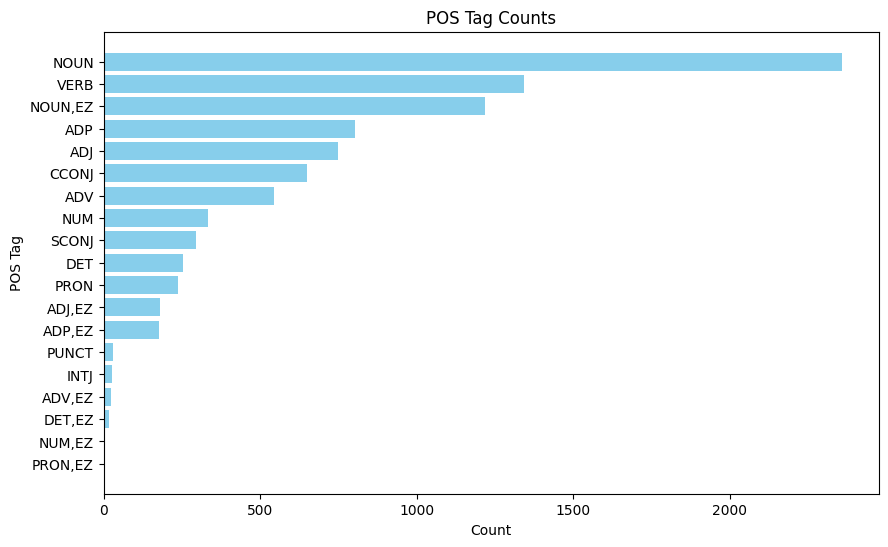

In [9]:
import matplotlib.pyplot as plt

tags = list(pos_tag_counts.keys())
counts = list(pos_tag_counts.values())
sorted_tags, sorted_counts = zip(*sorted(zip(tags, counts), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.barh(sorted_tags, sorted_counts, color='skyblue')
plt.xlabel('Count')
plt.ylabel('POS Tag')
plt.title('POS Tag Counts')
plt.gca().invert_yaxis()
plt.show()


## Top 15 Nouns

In [10]:
def extract_and_report_nouns(tagged_sentences, count=15):
    nouns = []
    for sentence in tagged_sentences:
        for word, tag in sentence:
            if tag == 'NOUN' or tag == 'NOUN,EZ':
                nouns.append(word)

    noun_counts = Counter(nouns)

    top_nouns = []
    top_counts = []
    for noun, count in noun_counts.most_common(count):
        top_nouns.append(noun)
        top_counts.append(count)

    return top_nouns, top_counts


In [11]:
top_nouns, top_counts = extract_and_report_nouns(pos_tagged_sentences)
print("Top 15 Most Repeated Nouns:")
for noun, count in zip(top_nouns, top_counts):
    print(f"{noun}: {count}")

Top 15 Most Repeated Nouns:
می: 98
گوشی: 72
کیفیت: 51
های: 49
استفاده: 41
ها: 35
قیمت: 33
خرید: 28
نسبت: 27
نظر: 27
پیشنهاد: 23
دستگاه: 23
میشه: 22
رو: 22
مدل: 21


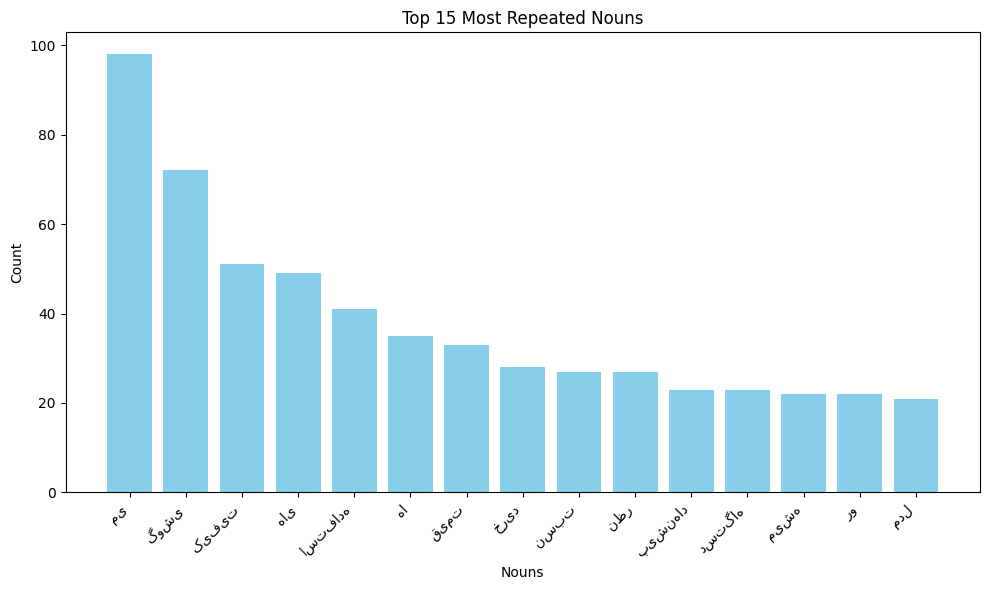

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(top_nouns, top_counts, color='skyblue')
plt.xlabel('Nouns')
plt.ylabel('Count')
plt.title('Top 15 Most Repeated Nouns')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()